# Pet's Faces Dataset

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [ ]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2022-06-05 16:20:44--  https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-gzip]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M  26.5MB/s    in 0.9s    

2022-06-05 16:20:45 (26.5 MB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [59]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
import glob
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [60]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())
# my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']


['/device:CPU:0', '/device:GPU:0']


Генерируем тестовую и валидационную выборки для 35 классовой классификации.

In [ ]:
subData = keras.preprocessing.image.ImageDataGenerator(rescale=1/255., 
                                                       validation_split=0.2, 
                                                       zoom_range=0.2, 
                                                       height_shift_range=10,
                                                       width_shift_range=10,
                                                       rotation_range = 90)

generator = subData.flow_from_directory(directory= 'petfaces',
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        batch_size=16,
                                        subset='training',
                                        shuffle = True
                                        )

Found 2583 images belonging to 35 classes.


Теперь переходим к созданию сверточной сети.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense
from tensorflow.keras.optimizers import Adam, Nadam, SGD
def create_model(optimizer_val='SGD',lr=10e-2, neuron_count=128):
  model = Sequential()
  model.add(Conv2D(64, (4, 4), padding='same', input_shape = (224,224,3), activation = 'relu'))
  model.add(MaxPooling2D((4, 4)))
  model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
  model.add(MaxPooling2D((3, 3)))
  model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D((3, 3)))
  model.add(Flatten())
  model.add(Dense(neuron_count*2,activation='relu'))
  model.add(Dense(neuron_count,activation='relu'))
  model.add(Dense(35,activation='softmax'))

  if optimizer_val == 'SGD':
    optimizer_ = SGD(learning_rate= lr)
  elif optimizer_val == 'Adam':
    optimizer_ = Adam(learning_rate= lr)
  elif optimizer_val == 'NAdam':
    optimizer_ = Nadam(learning_rate= lr)
  model.compile(optimizer=optimizer_,
                loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

Получим некоторую часть X и y из объекта generator для выполнения оптимизации гиперпараметров

In [ ]:
def get_X_y(generator, batch_count):
  X = []
  y = []
  for i in range (batch_count):
      data = generator.next()
      X.extend(data[0])
      y.extend(data[1])
  X = np.asarray(X)  
  y = np.asarray(y)  
  return X, y

In [ ]:
X, y = get_X_y(generator, 30)
print(X.shape)
print(y.shape)

(480, 224, 224, 3)
(480, 35)


In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=16)

#Initialize the parameter grid
nn_param_grid = {
'epochs': [15],     
'neuron_count':[64, 128],
'optimizer_val': ['Adam','SGD', 'NAdam'],
'lr':[0.01, 0.001, 0.0001]
}
#Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=nn_param_grid)
grid_result = grid.fit(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/15
24/24 [==============================] - 1s 27ms/step - loss: 4.0444 - accuracy: 0.0312
Epoch 2/15
24/24 [==============================] - 1s 26ms/step - loss: 3.5300 - accuracy: 0.0495
Epoch 3/15
24/24 [==============================] - 1s 26ms/step - loss: 3.5205 - accuracy: 0.0339
Epoch 4/15
24/24 [==============================] - 1s 25ms/step - loss: 3.5086 - accuracy: 0.0443
Epoch 5/15
24/24 [==============================] - 1s 26ms/step - loss: 3.5143 - accuracy: 0.0547
Epoch 6/15
24/24 [==============================] - 1s 26ms/step - loss: 3.5147 - accuracy: 0.0547
Epoch 7/15
24/24 [==============================] - 1s 29ms/step - loss: 3.5087 - accuracy: 0.0547
Epoch 8/15
24/24 [==============================] - 1s 31ms/step - loss: 3.5040 - accuracy: 0.0521
Epoch 9/15
24/24 [==============================] - 1s 31ms/step - loss: 3.4944 - accuracy: 0.0521
Epoch 10/15
24/24 [==============================] - 1s 32ms/step - loss: 3.4637 - accuracy: 0.0573
Epoch 11/

In [62]:
best_params = grid_result.best_params_
best_params

{'epochs': 15, 'lr': 0.001, 'neuron_count': 128, 'optimizer_val': 'NAdam'}

In [63]:
model = create_model(optimizer_val=best_params['optimizer_val'],
                     lr=best_params['lr'], neuron_count=best_params['neuron_count'])
model.summary()

Model: "sequential_282"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_846 (Conv2D)         (None, 224, 224, 64)      3136      
                                                                 
 max_pooling2d_846 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_847 (Conv2D)         (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_847 (MaxPooli  (None, 18, 18, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_848 (Conv2D)         (None, 18, 18, 64)        36928     
                                                                 
 max_pooling2d_848 (MaxPooli  (None, 6, 6, 64)      

In [64]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255., 
                                                       validation_split=0.2, 
                                                       zoom_range=0.2, 
                                                       height_shift_range=10,
                                                       width_shift_range=10,
                                                       rotation_range = 90,
                                                       horizontal_flip=True)

train_generator = datagen.flow_from_directory(directory= 'petfaces',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=16,
                                             subset='training',
                                            shuffle = True

                                             )

validation_generator = datagen.flow_from_directory(directory= 'petfaces',
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle = True,
                                                   batch_size = 16,
                                                   seed=7)

Found 2583 images belonging to 35 classes.
Found 628 images belonging to 35 classes.


In [65]:
history = model.fit(
        train_generator,
        validation_data = validation_generator,
        epochs=best_params['epochs'],
    )

Epoch 1/15
162/162 [==============================] - 37s 224ms/step - loss: 3.5447 - accuracy: 0.0569 - val_loss: 3.4468 - val_accuracy: 0.0701
Epoch 2/15
162/162 [==============================] - 36s 225ms/step - loss: 3.3690 - accuracy: 0.0670 - val_loss: 3.2963 - val_accuracy: 0.0892
Epoch 3/15
162/162 [==============================] - 35s 219ms/step - loss: 3.2185 - accuracy: 0.0937 - val_loss: 3.0482 - val_accuracy: 0.1258
Epoch 4/15
162/162 [==============================] - 36s 220ms/step - loss: 3.0083 - accuracy: 0.1436 - val_loss: 2.8055 - val_accuracy: 0.1815
Epoch 5/15
162/162 [==============================] - 36s 220ms/step - loss: 2.7783 - accuracy: 0.1936 - val_loss: 2.6306 - val_accuracy: 0.2420
Epoch 6/15
162/162 [==============================] - 36s 221ms/step - loss: 2.5912 - accuracy: 0.2393 - val_loss: 2.5058 - val_accuracy: 0.2707
Epoch 7/15
162/162 [==============================] - 36s 221ms/step - loss: 2.4374 - accuracy: 0.2838 - val_loss: 2.5096 - val_ac

In [66]:
X, y = get_X_y(validation_generator, 39)

In [67]:
validation_generator.class_indices

{'cat_Abyssinian': 0,
 'cat_Bengal': 1,
 'cat_Birman': 2,
 'cat_Bombay': 3,
 'cat_British': 4,
 'cat_Egyptian': 5,
 'cat_Maine': 6,
 'cat_Persian': 7,
 'cat_Ragdoll': 8,
 'cat_Russian': 9,
 'cat_Siamese': 10,
 'cat_Sphynx': 11,
 'dog_american': 12,
 'dog_basset': 13,
 'dog_beagle': 14,
 'dog_boxer': 15,
 'dog_chihuahua': 16,
 'dog_english': 17,
 'dog_german': 18,
 'dog_great': 19,
 'dog_havanese': 20,
 'dog_japanese': 21,
 'dog_keeshond': 22,
 'dog_leonberger': 23,
 'dog_miniature': 24,
 'dog_newfoundland': 25,
 'dog_pomeranian': 26,
 'dog_pug': 27,
 'dog_saint': 28,
 'dog_samoyed': 29,
 'dog_scottish': 30,
 'dog_shiba': 31,
 'dog_staffordshire': 32,
 'dog_wheaten': 33,
 'dog_yorkshire': 34}

In [68]:
def take_labels(batch): # Забирает номера классов из вектора лейблов
  res = []
  for i in batch:
    res.append(i.argmax())
  return np.array(res)

def top_acc(valid,n):# возвращает первые n предсказанных лейблов
  res = np.empty((0,n))
  for i in valid:
    ind = np.flip(i.argsort())[:n]
    res = np.append(res,[ind],axis=0)
    
  return res

def top3_acc(val_labels, pred): # считает top-3 accuracy
  sum_corr = 0
  for (i,elem) in enumerate(val_labels):
    if elem in pred[i]:
      sum_corr+=1
  res = sum_corr / val_labels.shape[0]
  return res

def top1_acc(val_labels, pred):# считает top-1 accuracy
  sum_corr = 0
  for (i,elem) in enumerate(val_labels):
    if elem == pred[i][0]:
      sum_corr+=1
  res = sum_corr / val_labels.shape[0]
  return res

def binary_class(val_labels,pred): # бинарная классификация
  v,r = [],[]
  for i in val_labels:
    if i < 12:
      v.append(0)
    else:
      v.append(1)
  for i in pred:
     if i < 12:
      r.append(0)
     else:
      r.append(1)
  return v,r


In [69]:
res = model.predict_on_batch(X)
val_labels = take_labels(y)
top3 = top_acc(res,3)
top1 = top_acc(res,1)

Считаем top1-accuracy и top3-accuracy, видим, что top-1 совпадает с предсказаниями модели, а top-3 больше, чем top-1, так как мы смотрим на 3 наиболее вероятных лейбла.

In [70]:
top_1 = top1_acc(val_labels,top1)
top_3 = top3_acc(val_labels, top3)
print("top1-accuracy:", top_1)
print("top3-accuracy:", top_3)

top1-accuracy: 0.44711538461538464
top3-accuracy: 0.7355769230769231


Ранее мы уже подсчитали top-1 и top-3 accuracy, тпеперь построим Conffusion Matrix. Для этого возьмем предсказанные моделью лейблы и их истинное значение.

Теперь преобразуем предсказанные лейблы и истинные к двоичной форме: 0 - кошка, 1 - собака

In [71]:
val_labels.shape

(624,)

In [72]:
top1 = np.array(top1)
top1.resize(val_labels.shape)
v,r = binary_class(val_labels,top1)

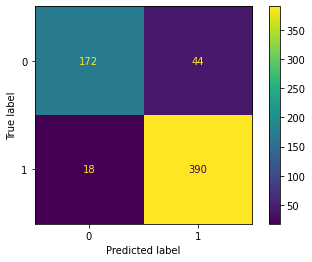

In [73]:
ConfusionMatrixDisplay.from_predictions(v, r)
plt.show()

In [74]:
(172+390)/(172+390+18+44)

0.9006410256410257

Как мы видим, модель неплохо справилась с задачей классификации кошек и собак, точность  = 0,9